In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import h5py
import pickle
import numpy as np

In [2]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens), len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l), idx] = l
    print(len(arrs))
    return arr.mean(axis=-1), arr.std(axis=-1) / np.sqrt(len(arrs))


def smooth(x, n):
    return np.convolve(x, np.ones((n,)) / n, mode='valid')

In [6]:
def plot_1(*args, window=None, title='Online User Study: Typing with Eye Gaze', legend_loc=None, font_size=24, 
           ncol=1, ylim=None, figsize=(12, 9), save_path=None):
    matplotlib.rcParams.update({'font.size': font_size})

    plt.figure(figsize=figsize)
    average_accuracies = []
    min_len = 1001

    for i, arg in enumerate(args):
        accuracies = []
        corrects = []
        for (path, subdirs, files) in os.walk(arg):
            for file in files:
                if file == 'data.hdf5':
                    data = h5py.File(os.path.join(path, file), 'r')
                    accuracy = np.equal(data['targets'][()], data['actions'][()]).astype(np.float)
                    corrects.append(accuracy)
                    if window is not None:
                        accuracy = smooth(accuracy, window)
                    accuracies.append(accuracy)

        mean, std_err = tolerant_mean(accuracies)
        min_len = min(min_len, min([len(x) for x in accuracies]))
        if '/' not in arg:
            label = arg
        else:
            label = arg[arg.rindex('/') + 1:]
        if label == 'x2t':
            label = 'X2T (Our Method)'
            color = 'tab:orange'
        elif label == 'x2t_no_pretrain':
            label = 'X2T without Offline Pretraining'
            color = 'tab:cyan'
        elif label == 'x2t_no_prior':
            label = 'X2T without Prior Policy'
            color = 'tab:red'
        elif label == 'default':
            label = 'Default Interface (Baseline)'
            color = 'tab:gray'
        else:
            label = 'X2T without Online Learning'
            color = 'tab:purple'
        plt.plot(np.arange(len(mean)), mean, label=label, c=color)
        plt.fill_between(np.arange(len(mean)), mean - std_err, mean + std_err, alpha=.1, color=color)

    plt.xlabel('Number of User Interactions')
    plt.ylabel('Action Prediction Accuracy')
    plt.title(title)
    plt.xlim(0, min_len)
    leg = plt.legend(loc=legend_loc, ncol=ncol)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
    if ylim is not None:
        plt.ylim(ylim)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

12
12


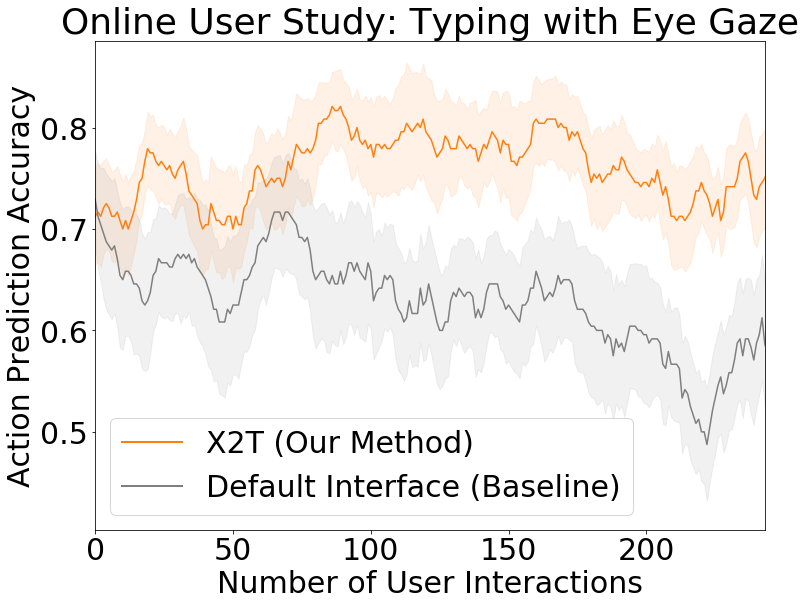

In [7]:
plot_1('../experiments/gaze_study/x2t', '../experiments/gaze_study/default', window=20, font_size=30)

In [9]:
def plot_2(path1, path2, save_path=None):
    matplotlib.rcParams.update({'font.size': 20})

    plt.figure(figsize=(9, 9))
    average_accuracies = []

    for i, arg in enumerate((path1, path2)):
        accuracies = []
        for (path, subdirs, files) in os.walk(arg):
            for file in files:
                if file == 'data.hdf5':
                    data = h5py.File(os.path.join(path, file), 'r')
                    accuracy = np.equal(data['targets'][()], data['actions'][()]).astype(np.float)
                    accuracies.append(accuracy)
                    
        average_accuracies.append([np.mean(user) for user in accuracies])

    plt.xlabel('Cumulative Accuracy of Default Interface (Baseline)')
    plt.ylabel('Cumulative Accuracy of X2T (Our Method)')
    plt.xlim([0.3, 1])
    plt.ylim([0.3, 1])

    plt.scatter(average_accuracies[0], average_accuracies[1], color='tab:orange', s=200)
    plt.vlines(average_accuracies[0], average_accuracies[0], average_accuracies[1], color='tab:orange',
               linestyle="dotted")
    plt.plot([0, 1], [0, 1], c='tab:gray', linestyle='dashed')
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

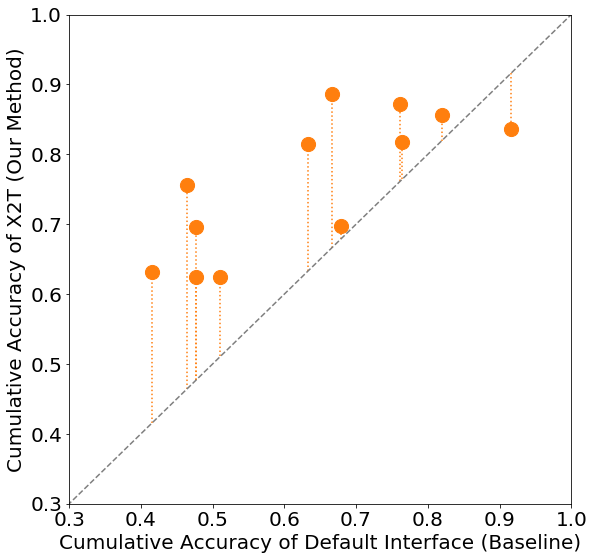

In [10]:
plot_2('../experiments/gaze_study/default', '../experiments/gaze_study/x2t')

In [16]:
def plot_3(path1, index, save_path=None):
    matplotlib.rcParams.update({'font.size': 30})

    plt.figure(figsize=(12, 12))
    baseline = {}
    x2t = {}


    for (path, subdirs, files) in os.walk(path1):
        for file in files:
            if file == 'baseline_estimates.pkl':
                with open(os.path.join(path, file), 'rb') as f:
                    data = pickle.load(f)
                baseline[int(path[path.rindex('/') + 1])] = data[index]
                
            if file == 'data.hdf5':
                data = h5py.File(os.path.join(path, file), 'r')
                accuracy = np.equal(data['targets'][()], data['actions'][()])
                accuracy = accuracy[(data['targets'][()] == index).astype(bool)]
                x2t[int(path[path.rindex('/') + 1])] = accuracy
            
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks([])
    plt.yticks([])
    
    angles = [(2 * np.pi * k / 8) for k in range(8)]
    targets = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
    
    x_targets, y_targets = zip(*targets)
    colors = ['none'] * len(targets)
    linestyles = ['--'] * index + ['-'] + ['--'] * (len(targets) - index - 1)
    linewidths = [1] * index + [3] + [1] * (len(targets) - index - 1)
    plt.scatter(x_targets, y_targets, c=colors, edgecolors='tab:gray', s=2000, linestyles=linestyles,
               linewidths=linewidths)
    
    for i in range(len(baseline)):
        for (estimate, baseline_correct), x2t_correct in zip(baseline[i], x2t[i]):
            if x2t_correct:
                marker = 'o'
                if baseline_correct:
                    color = 'tab:gray'
                    alpha = 0.25
                    ms = 6
                else:
                    color = 'tab:orange'
                    alpha = 1
                    ms = 10
                point, = plt.plot(estimate[0], estimate[1], marker=marker, color=color, alpha=alpha, ms=ms)

    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

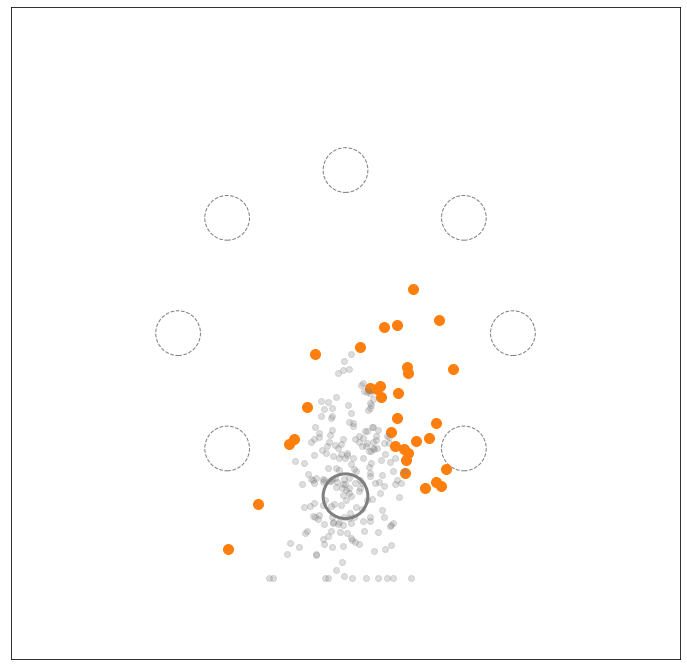

In [17]:
plot_3('../experiments/gaze_study/x2t', 6)

In [14]:
def plot_4(*args, window=None, save_path=None):
    matplotlib.rcParams.update({'font.size': 24})

    plt.figure(figsize=(12, 9))
    average_accuracies = []
    min_len = 300

    for i, arg in enumerate(args):
        accuracies = []
        corrects = []
        for (path, subdirs, files) in os.walk(arg):
            for file in files:
                if file == 'data.hdf5':
                    data = h5py.File(os.path.join(path, file), 'r')
                    accuracy = np.equal(data['targets'][()], data['actions'][()]).astype(np.float)
                    corrects.append(accuracy)
                    if window is not None:
                        accuracy = smooth(accuracy, window)
                    accuracies.append(accuracy)

        mean, std_err = tolerant_mean(accuracies)
        min_len = min(min_len, min([len(x) for x in accuracies]))
        if '/' not in arg:
            label = arg
        else:
            label = arg[arg.rindex('/') + 1:]
        if label == 'x2t':
            label = 'X2T (Our Method)'
            color = 'tab:orange'
        elif label == 'x2t_on_default_data':
            label = 'X2T on Inputs Intended for Default Interface'
            color = 'tab:cyan'
        elif label == 'default_on_x2t_data':
            label = 'Default Interface on Inputs Intended for X2T'
            color = 'tab:gray'
        plt.plot(np.arange(len(mean)), mean, label=label, c=color)
        plt.fill_between(np.arange(len(mean)), mean - std_err, mean + std_err, alpha=.1, color=color)

    plt.xlabel('Number of User Interactions')
    plt.ylabel('Action Prediction Accuracy')
    plt.title('Co-adaptation between User and Interface')
    plt.xlim(0, min_len)
    leg = plt.legend(loc='lower right')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [ ]:
# must run scripts/coadapt.sh before able to plot

plot_4('../experiments/gaze_study/x2t', '../experiments/offline_gaze/x2t_on_default_data',
       '../experiments/offline_gaze/default_on_x2t_data', window=20)

In [20]:
def reward_acc(*args):
    total_correct_pos = []
    total_correct_neg = []
    total_incorrect_pos = []
    total_incorrect_neg = []

    for i, arg in enumerate(args):
        accuracies = []
        corrects = []
        for (path, subdirs, files) in os.walk(arg):
            for file in files:
                if file == 'data.hdf5':
                    data = h5py.File(os.path.join(path, file), 'r')
                    correct = np.equal(data['targets'][()], data['actions'][()]).astype(np.float)
                    rewards = data['rewards'][()]
                    rewards = np.where(rewards==-1, 1, rewards)
                    
                    
                    total_correct_pos.extend(rewards[(correct == 1).astype(bool)])
                    total_correct_neg.extend(1 - rewards[(correct == 1).astype(bool)])
                    
                    total_incorrect_pos.extend(rewards[(correct == 0).astype(bool)])
                    total_incorrect_neg.extend(1 - rewards[(correct == 0).astype(bool)])

                    
    return np.sum(total_correct_pos), np.sum(total_correct_neg), np.sum(total_incorrect_pos), np.sum(total_incorrect_neg)


In [24]:
a, b, c, d = reward_acc('../experiments/gaze_study/x2t', '../experiments/gaze_study/default',
                        '../experiments/gaze_study/offline')

In [25]:
a, b, c, d

(6704, 26, 103, 2911)

In [ ]:
# must run scripts/ablation.sh before able to plot

plot_1('../experiments/sim_uji/default', '../experiments/sim_uji/x2t', '../experiments/sim_uji/x2t_no_pretrain',
       '../experiments/sim_uji/x2t_no_online', '../experiments/sim_uji/x2t_no_prior',
       title='Observational Study: Handwriting Recognition', window=20, font_size=18, ncol=2,
       legend_loc='lower right', ylim=0, figsize=(14, 14))

In [8]:
def plot_5(path1, path2, save_path=None):
    matplotlib.rcParams.update({'font.size': 24})

    plt.figure(figsize=(16, 9))
    error_rates = [np.round(rate, 2) for rate in np.arange(0, 0.55, 0.05)]
        
    total_accuracies = []
    for error_rate in error_rates:
        accuracies = []
        for (path, subdirs, files) in os.walk(os.path.join(path1, str(error_rate))):
            for file in files:
                if file == 'data.hdf5':
                    data = h5py.File(os.path.join(path, file), 'r')
                    accuracy = np.equal(data['targets'][()], data['actions'][()]).astype(np.float)
                    accuracies.append(np.mean(accuracy))
        total_accuracies.append(accuracies)
    mean = np.mean(total_accuracies, axis=1)
    std_err = np.std(total_accuracies, axis=1) / len(total_accuracies[0])

    default_accuracies = []
    for (path, subdirs, files) in os.walk(path2):
        for file in files:
            if file == 'data.hdf5':
                data = h5py.File(os.path.join(path, file), 'r')
                accuracy = np.equal(data['targets'][()], data['actions'][()]).astype(np.float)
                default_accuracies.append(np.mean(accuracy))
    mean_default = np.mean(default_accuracies)
    std_err_default = np.std(default_accuracies) / len(default_accuracies)
    
    plt.plot(error_rates, mean, marker='o', color='tab:orange', label='X2T (Our Method)')
    plt.fill_between(error_rates, mean - std_err, mean + std_err, alpha=.1, color='tab:orange')
    
    empirical_acc = (26 + 103) / (6704 + 26 + 103 + 2911)
    plt.xticks(error_rates)
    plt.plot(error_rates, len(error_rates) * [mean_default], label='Default Interface', color='tab:gray')
    plt.fill_between(error_rates, mean_default - std_err_default, mean_default + std_err_default, alpha=.1, color='tab:gray')
    plt.vlines(empirical_acc, 0, 1, linewidth=5, color='tab:cyan', linestyle="dotted", label='Empirical Mislabeling Rate in Online User Study')
    plt.xlabel('Reward Mislabeling Rate')
    plt.ylabel('Action Prediction Accuracy')
    plt.title('Sensitivity to Noisy Rewards')
    plt.ylim((0.6, 0.8))
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [ ]:
# must run scripts/rew_noise.sh before able to plot

plot_5('../experiments/offline_gaze/rew_noise/', '../experiments/gaze_study/default')